<a href="https://colab.research.google.com/github/pipeton8/6.864-advanced-nlp/blob/main/Assignments/Assignment%202/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%bash
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
from IPython.display import clear_output

!rm -rf hw2
!wget https://github.com/pipeton8/6.864-advanced-nlp/raw/main/Assignments/Assignment%202/lab_util.py -P hw2
!wget https://github.com/pipeton8/6.864-advanced-nlp/raw/main/Assignments/Assignment%202/reviews.csv -P hw2

clear_output()

In [2]:
import sys
sys.path.insert(1,'/content/hw2')

import csv
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lab_util

from sklearn.pipeline              import Pipeline
from sklearn.decomposition         import TruncatedSVD, PCA
from sklearn.linear_model          import LogisticRegression
from sklearn.ensemble              import RandomForestClassifier
from sklearn.svm                   import LinearSVC
from sklearn.neural_network        import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors             import KNeighborsClassifier

from tqdm.auto import tqdm

# Introduction

In this notebook, you will find code scaffolding for the implementation portion of Homework 2. There are certain parts of the scaffolding marked with `# Your code here!` comments where you can fill in code to perform the specified tasks. After implementing the methods in this notebook, you will need to design and perform experiments to evaluate each method and respond to the questions in the Homework 2 handout (available on Canvas). You should be able to complete this assignment without changing any of the scaffolding code, just writing code to fill in the scaffolding and run experiments.

## Dataset

We're going to be working with a dataset of product reviews. The following cell loads the dataset and splits it into training, validation, and test sets.

In [3]:
data = []
n_positive = 0
n_disp = 0

with open("hw2/reviews.csv") as reader:
  csvreader = csv.reader(reader)
  next(csvreader)
  for id, review, label in csvreader:
    label = int(label)

    # hacky class balancing
    if label == 1:
      if n_positive == 2000:
        continue

      n_positive += 1

    if len(data) == 4000:
      break

    data.append((review, label))
    
    if n_disp > 5:
      continue

    n_disp += 1

    print("review:", review)
    print("rating:", label, "(good)" if label == 1 else "(bad)")
    print()

print(f"Read {len(data)} total reviews.")

# Shuffle before splitting
np.random.shuffle(data)
reviews, labels = zip(*data)

# Training (3000 samples)
train_reviews = reviews[:3000]
train_labels = labels[:3000]

# Validation (500 samples)
val_reviews = reviews[3000:3500]
val_labels = labels[3000:3500]

# Testing (500 samples)
test_reviews = reviews[3500:]
test_labels = labels[3500:]

review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

# Part 1: word representations via matrix factorization

First, we'll construct the term-document matrix (look at `/content/hw2/lab_util.py` in the file browser on the left if you want to see how this works).

In [4]:
vectorizer = lab_util.CountVectorizer()
vectorizer.fit(train_reviews)
td_matrix = vectorizer.transform(train_reviews).T
print(f"TD matrix is {td_matrix.shape[0]} x {td_matrix.shape[1]}")

TD matrix is 2010 x 3000


First, implement the function `learn_reps_lsa` that computes word representations via latent semantic analysis. The `sklearn.decomposition` or `np.linalg` packages may be useful.

In [66]:
def idf_matrix(matrix, idf_weight = 'idf'):
  """ Given a |V| x n TD matrix, returns the |V| IDF vector associated, where
      idf(w) = log (# documents / (1 + # documents that contain w) )
  """
  reviews_per_word = np.sum(matrix > 0, axis=1, keepdims=True)
  reviews = matrix.shape[1]

  if idf_weight == 'idf':
    return np.log(reviews/(1+reviews_per_word))

def tf_matrix(matrix, tf_weight = 'raw'):
  """
    Given a |V| x n TD matrix, returns the |V| x n tf matrix, weighted according
    to tf_weight.
  """

  if tf_weight == 'raw':
    tf_matrix = matrix

  elif tf_weight == 'term frequency':
    tf_matrix = matrix/matrix.sum()

  elif tf_weight == 'log normalization':
    tf_matrix = np.log(1+matrix)

  elif tf_weight.find('double') != -1:
    try:
      dash_pos = tf_weight.find('-')
      k = float(tf_weight[dash_pos+1:])
      tf_matrix =  k + (1-k) * matrix/matrix.max(axis=0,keepdims=True)
    except:
      print("Double-k misspecified, raw weight applied.")
      tf_matrix = matrix

  return tf_matrix

def learn_reps_lsa(matrix, rep_size, tf_weight='raw', tf_idf=False, idf_weight='idf'):
    # `matrix` is a `|V| x n` matrix (usually a TD matrix), 
    # where `|V|` is the number of words in the vocabulary and `n`
    # is the number of reviews in the (training) corpus.
    # This function should return a `|V| x rep_size` matrix with each
    # row corresponding to a word representation.
    
    LSA_matrix = tf_matrix(matrix, tf_weight)

    if tf_idf:
      # Get IDF vector
      idf = idf_matrix(matrix, idf_weight)

      # Compute TF-IDF matrix
      LSA_matrix = LSA_matrix * idf

    # Initialize svd object
    svd = TruncatedSVD(n_components=rep_size)

    # Decompose TF-IDF matrix
    return svd.fit_transform(LSA_matrix)

Let's look at some representations:

In [6]:
words = ["good", "bad", "cookie", "jelly", "dog", "the", "3"]
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]

In [7]:
reps = learn_reps_lsa(td_matrix, 500)
lab_util.show_similar_words(vectorizer.tokenizer, reps, show_tokens)

good 13
  a 1.105
  . 1.108
  and 1.178
  for 1.194
  but 1.195
bad 542
  news 1.363
  a 1.400
  . 1.418
  the 1.443
  , 1.453
cookie 1086
  nana's 0.703
  cookies 0.811
  oreos 1.215
  bars 1.277
  bites 1.321
jelly 1563
  bean 1.099
  twist 1.358
  tooth 1.393
  quantity 1.463
  superior 1.476
dog 836
  food 1.120
  pet 1.229
  foods 1.238
  allergies 1.253
  dogs 1.298
the 28
  . 0.334
  <unk> 0.348
  of 0.393
  to 0.431
  and 0.448
3 143
  8 1.182
  <unk> 1.216
  . 1.226
  of 1.232
  , 1.245


We've been operating on the raw count matrix, but in class we discussed several reweighting schemes aimed at making LSA representations more informative. 

Here, implement the TF-IDF transform and see how it affects learned representations. While it is okay (and in fact encouraged) to use vectorized numpy operations, you should refrain from using pre-implemented library functions for computing TF-IDF.

How does TF-IDF normalization change the learned similarity function?

In [8]:
reps_tfidf = learn_reps_lsa(td_matrix, 500, tf_idf=True)
lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)

good 13
  . 1.032
  a 1.033
  but 1.096
  and 1.099
  for 1.117
bad 542
  a 1.339
  . 1.359
  news 1.372
  the 1.392
  taste 1.407
cookie 1086
  nana's 0.714
  cookies 0.921
  bars 1.303
  oreos 1.369
  bites 1.391
jelly 1563
  bean 1.201
  tooth 1.363
  twist 1.392
  superior 1.474
  cardboard 1.493
dog 836
  food 1.104
  foods 1.207
  pet 1.261
  dogs 1.285
  allergies 1.341
the 28
  . 0.209
  <unk> 0.263
  of 0.295
  and 0.313
  to 0.330
3 143
  8 1.119
  . 1.170
  <unk> 1.174
  of 1.184
  , 1.210


Now that we have some representations, let's see if we can do something useful with them.

Below, implement a feature function that represents a document as the sum of its
learned word embeddings.

The remaining code trains a logistic regression model on a set of *labeled* reviews; we're interested in seeing how much representations learned from *unlabeled* reviews improve classification.

(Note: the staff solutions for each of the three featurizers achieve accuracies of between .78 and .83 with the full training corpus (3000 examples).)

In [9]:
def word_featurizer(xs):
    # normalize
    return xs / np.sqrt((xs ** 2).sum(axis=1, keepdims=True))

def lsa_featurizer(xs, reps, idf_weighting = False):
    # This function takes in a `|D| x |V|` TD matrix in which each row contains
    # the word counts for the given review.
    # It should return a matrix where each row contains the learned feature
    # representation of each review (e.g. the sum of LSA word representations).
    # (Hint: use TF-IDF LSA features, which should be a global variable after
    # running the previous cell; no need to pass it in as an argument.)
    feats = np.zeros((xs.shape[0],reps.shape[1]))

    if idf_weighting:
      idf = idf_matrix(xs.T, 'idf')
    else:
      idf = np.ones_like(feats[0,:])

    for i in range(xs.shape[0]):
      doc_wordDummies = (xs[i,:] > 0).T.reshape((-1,1))
      feats[i,:] = np.sum(doc_wordDummies * idf * reps,axis=0, keepdims=True)

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

# We've implemented the remainder of the training and evaluation pipeline,
# so you likely won't need to modify the following four functions.
def combo_featurizer(xs, reps, idf_weighting = False):
    return np.concatenate((word_featurizer(xs), lsa_featurizer(xs, reps, idf_weighting=idf_weighting)), axis=1)

def train_model(xs, ys, featurizer, featurizer_args, featurizer_kwargs, model):
    if reps is None: 
      xs_featurized = featurizer(xs, *featurizer_args, **featurizer_kwargs)
    else:
      xs_featurized = featurizer(xs, *featurizer_args, **featurizer_kwargs)

    model.fit(xs_featurized, ys)

    return model

def eval_model(model, xs, ys, featurizer, featurizer_args, featurizer_kwargs):
    if reps is None:
      xs_featurized = featurizer(xs, *featurizer_args, **featurizer_kwargs)
    else:
      xs_featurized = featurizer(xs, *featurizer_args, **featurizer_kwargs)

    pred_ys = model.predict(xs_featurized)

    return np.mean(pred_ys == ys)

def training_experiment(name, n_train, model, featurizer, featurizer_args = [], featurizer_kwargs = {}, verbose=True):
    if verbose:
      print(f"{name} features, {n_train} examples")

    train_xs = vectorizer.transform(train_reviews[:n_train])
    train_ys = train_labels[:n_train]
    test_xs = vectorizer.transform(test_reviews)
    test_ys = test_labels
    model = train_model(train_xs, train_ys, featurizer, featurizer_args, featurizer_kwargs, model)
    acc = eval_model(model, test_xs, test_ys, featurizer, featurizer_args, featurizer_kwargs)

    if verbose:
      print(f"Accuracy is {acc*100:.2f}%")
      print("")

    return acc

In [10]:
# Train
n_train = 3000
embed_size = 500
model = LogisticRegression()

reps_tfidf = learn_reps_lsa(td_matrix, embed_size, tf_idf=True)
acc = training_experiment("word", n_train, model, word_featurizer)
acc = training_experiment("lsa", n_train, model, lsa_featurizer, featurizer_args=[reps_tfidf])
acc = training_experiment("combo", n_train, model, combo_featurizer, featurizer_args=[reps_tfidf])
print()

word features, 3000 examples
Accuracy is 74.80%

lsa features, 3000 examples
Accuracy is 74.80%

combo features, 3000 examples
Accuracy is 76.60%




**Part 1: Lab writeup**

Part 1 of your lab report should discuss any implementation details that were important to filling out the code above, as well as your answers to the questions in Part 1 of the Homework 2 handout. Below, you can set up and perform experiments that answer these questions (include figures, plots, and tables in your write-up as you see fit).

## Experiments for Part 1

### Part (a)

In [11]:
def cosine_similarity(A,B, axis=0):
  """
  Given matrices A and B, computes cosine similarity between column vectors if
  axis = 0 and between rows if axis = 1.
  """
  norm_A = np.linalg.norm(A,axis=axis)
  norm_B = np.linalg.norm(B,axis=axis)
  
  return np.sum(A * B,axis=axis)/(norm_A*norm_B)

Singular values coincide: Yes
Share of vectors with similarity (in absolute value) equal or greater that 0.90: 0.79
Share of vectors with similarity (in absolute value) equal or greater that 0.95: 0.78
Share of vectors with similarity (in absolute value) equal or greater that 0.99: 0.74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


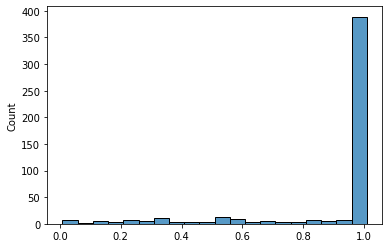

In [12]:
# Set embed_size and compute W_tt
embed_size = 500
w_tt = td_matrix @ td_matrix.T

# Initialize SVD objects
svd_TD = TruncatedSVD(n_components=embed_size, random_state=0)
svd_TT = TruncatedSVD(n_components=embed_size, random_state=0)

# Obtain low rand representation
decomposed_TD = svd_TD.fit_transform(td_matrix)
decomposed_TT = svd_TT.fit_transform(w_tt)

# Obtain left_singular vectors (in absolute value)
left_singular_TD = decomposed_TD/svd_TD.singular_values_
left_singular_TT = decomposed_TT/svd_TT.singular_values_

# Singular value similarity
values_TD = svd_TD.singular_values_
values_TT = svd_TT.singular_values_
value_similarity = cosine_similarity(values_TD, np.sqrt(values_TT))

# Compute cosine similarity between each column
vector_similarity = cosine_similarity(left_singular_TD,left_singular_TT)
vector_similarity = np.abs(vector_similarity)

ax = sns.histplot(vector_similarity, binwidth=0.05)
ax.set_xticks([0.2*x for x in range(6)])

print(f"Singular values coincide: " + "Yes"*(value_similarity>=0.99) + "No"*(value_similarity<0.99))
print(f"Share of vectors with similarity (in absolute value) equal or greater that 0.90: {(vector_similarity>=0.90).sum()/embed_size:.2f}")
print(f"Share of vectors with similarity (in absolute value) equal or greater that 0.95: {(vector_similarity>=0.95).sum()/embed_size:.2f}")
print(f"Share of vectors with similarity (in absolute value) equal or greater that 0.99: {(vector_similarity>=0.99).sum()/embed_size:.2f}")

### Part (b)

In [19]:
words = ['the', 'dog', '3', 'good']
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]

In [27]:
embed_size = 1000
kwargs = {'tf_weight'  : 'term frequency',
          'tf_idf'     : True}

reps = learn_reps_lsa(td_matrix, embed_size, **kwargs)
lab_util.show_similar_words(vectorizer.tokenizer, reps, show_tokens)

the 28
  . 0.262
  <unk> 0.305
  of 0.354
  and 0.383
  to 0.388
dog 836
  food 1.122
  foods 1.267
  dogs 1.304
  pet 1.340
  cheap 1.463
3 143
  . 1.204
  <unk> 1.205
  8 1.211
  of 1.226
  , 1.241
good 13
  . 1.078
  a 1.084
  and 1.154
  but 1.178
  for 1.181


### Part (c)

#### Different training sizes

In [52]:
# Different training sizes
n_trains = [500*i for i in range(1,7)]
embed_size = 500
model = LogisticRegression()
accs = {'word'  : [],
        'lsa'   : [],
        'combo' : []
        }

features = ['word', 'lsa', 'combo']
featurizers = [word_featurizer, lsa_featurizer, combo_featurizer]

reps = learn_reps_lsa(td_matrix, embed_size, tf_weight='term frequency', tf_idf=True)

for n_train in tqdm(n_trains):
  for feature,featurizer in zip(features,featurizers):
    if feature == 'word':
      accs[feature].append(training_experiment(feature, n_train, model, featurizer, verbose=False))
    else:
      accs[feature].append(
          training_experiment(feature, n_train, model, featurizer, 
                              featurizer_args=[reps], 
                              featurizer_kwargs={'idf_weighting' : False}, 
                              verbose=False))

  0%|          | 0/6 [00:00<?, ?it/s]

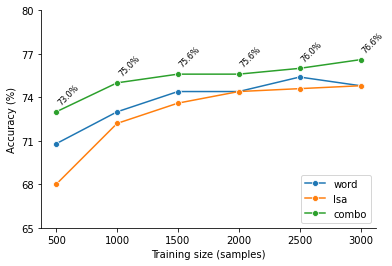

In [58]:
offset = (0,0.5)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for feature in features:
  x = n_trains
  y = [acc*100 for acc in accs[feature]]
  sns.lineplot(x=x, y=y, label=feature, marker='o', ax=ax)

  if feature == 'combo':
    for x_i,y_i in zip(x,y):
      s = f'{y_i:.1f}%'
      ax.text(x=x_i+offset[0], 
              y=y_i+offset[1],
              rotation=45,
              fontsize=8,
              s=s)

plt.yticks([65 + 3*x for x in range(6)])
plt.ylabel("Accuracy (%)")
plt.xticks(n_trains)
plt.xlabel("Training size (samples)")
plt.legend(loc='lower right')

#### Different embedding sizes

In [28]:
# Different embedding sizes
n_train = 3000
embed_sizes = [100*i for i in range(1,11)]
model = LogisticRegression()
accs = {'word'  : [],
        'lsa'   : [],
        'combo' : []
        }

features = ['word', 'lsa', 'combo']
featurizers = [word_featurizer, lsa_featurizer, combo_featurizer]

for embed_size in tqdm(embed_sizes):
  reps = learn_reps_lsa(td_matrix, embed_size, tf_weight='term frequency', tf_idf=True)

  for feature,featurizer in zip(features,featurizers):
    if feature == 'word':
      accs[feature].append(training_experiment(feature, n_train, model, featurizer, verbose=False))
    else:
      accs[feature].append(
          training_experiment(feature, n_train, model, featurizer, 
                              featurizer_args=[reps], 
                              featurizer_kwargs={'idf_weighting' : False}, 
                              verbose=False))

  0%|          | 0/10 [00:00<?, ?it/s]

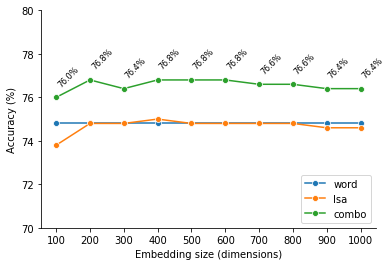

In [49]:
offset = (0,0.5)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for feature in features:
  x = embed_sizes
  y = [acc*100 for acc in accs[feature]]
  sns.lineplot(x=x, y=y, label=feature, marker='o', ax=ax)

  if feature == 'combo':
    for x_i,y_i in zip(x,y):
      s = f'{y_i:.1f}%'
      ax.text(x=x_i+offset[0], 
              y=y_i+offset[1],
              rotation=45,
              fontsize=8,
              s=s)

plt.yticks([70 + 2*x for x in range(6)])
plt.ylabel("Accuracy (%)")
plt.xticks(embed_sizes)
plt.xlabel("Embedding size (dimensions)")
plt.legend(loc='lower right')

### Different classifiers

In [69]:
# Different classifiers
n_train = 3000
embed_size = 500
models = [LogisticRegression(), RandomForestClassifier(), LinearSVC(), 
          MLPClassifier(), QuadraticDiscriminantAnalysis(), 
          KNeighborsClassifier(n_neighbors=3),KNeighborsClassifier(n_neighbors=5)]
model_names = ['Logit', 'Random Forest', 'SVM', 'Neural Network', 'QDA', '3-NN', '5-NN']

accs_classifiers = {'word'  : [],
                    'lsa'   : [],
                    'combo' : []
                  }

features = ['word', 'lsa', 'combo']
featurizers = [word_featurizer, lsa_featurizer, combo_featurizer]

reps = learn_reps_lsa(td_matrix, embed_size, tf_weight='term frequency', tf_idf=True)

for model in tqdm(models):
  for feature,featurizer in zip(features,featurizers):
    if feature == 'word':
      accs_classifiers[feature].append(training_experiment(feature, n_train, model, featurizer, verbose=False))
    else:
      accs_classifiers[feature].append(
          training_experiment(feature, n_train, model, featurizer, 
                              featurizer_args=[reps], 
                              featurizer_kwargs={'idf_weighting' : False}, 
                              verbose=False))

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [70]:
print("Max accuracies:")
for feature in features:
  print(" "*3 + f"{feature}: {sorted(accs[feature])[-1]*100:.2f}%")

Max accuracies:
   word: 82.20%
   lsa: 82.80%
   combo: 84.80%


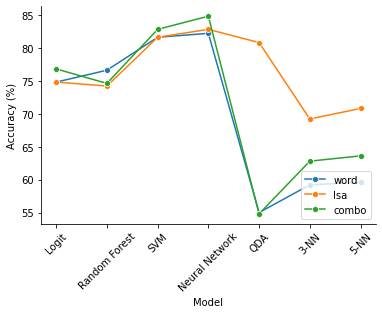

In [71]:
offset = (0,0.5)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for feature in features:
  x = model_names
  y = [acc*100 for acc in accs[feature]]
  sns.lineplot(x=x, y=y, label=feature, marker='o', ax=ax)

  # if feature == 'combo':
  #   for x_i,y_i in zip(x,y):
  #     s = f'{y_i:.1f}%'
  #     ax.text(x=x_i+offset[0], 
  #             y=y_i+offset[1],
  #             rotation=45,
  #             fontsize=7,
  #             s=s)

# plt.yticks([75 + 2*x for x in range(6)])
plt.ylabel("Accuracy (%)")
plt.xticks(model_names, rotation=45)
plt.xlabel("Model")
plt.legend(loc='lower right')

fig.show()

### Best classifier with different weighting

In [ ]:
# Different embedding sizes
n_train = 3000
embed_size = 500
model = LogisticRegression()
accs_weights = {'word'  : [],
        'lsa'   : [],
        'combo' : []
        }

tf_weights = ['raw', 'term frequency', 'log normalization', 
              'double-0.25', 'double-0.5', 'double-0.75']

features = ['word', 'lsa', 'combo']
featurizers = [word_featurizer, lsa_featurizer, combo_featurizer]

for tf_weight in tqdm(tf_weights):
  reps = learn_reps_lsa(td_matrix, embed_size, tf_weight=tf_weight, tf_idf=True)

  for feature,featurizer in zip(features,featurizers):
    if feature == 'word':
      accs_weights[feature].append(training_experiment(feature, n_train, model, featurizer, verbose=False))
    else:
      accs_weights[feature].append(
          training_experiment(feature, n_train, model, featurizer, 
                              featurizer_args=[reps], 
                              featurizer_kwargs={'idf_weighting' : False}, 
                              verbose=False))

  0%|          | 0/6 [00:00<?, ?it/s]

ValueError: ignored

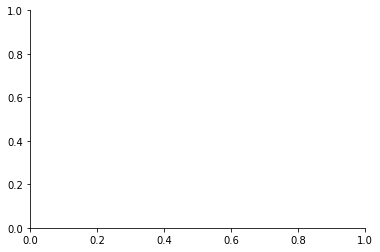

In [72]:
offset = (0,0.5)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for feature in features:
  x = tf_weights
  y = [acc*100 for acc in accs_weights[feature]]
  sns.lineplot(x=x, y=y, label=feature, marker='o', ax=ax)

  # if feature == 'combo':
  #   for x_i,y_i in zip(x,y):
  #     s = f'{y_i:.1f}%'
  #     ax.text(x=x_i+offset[0], 
  #             y=y_i+offset[1],
  #             rotation=45,
  #             fontsize=7,
  #             s=s)

# plt.yticks([75 + 2*x for x in range(6)])
plt.ylabel("Accuracy (%)")
plt.xticks(tf_weights, rotation=45, rotation_mode='anchor')
plt.xlabel("Model")
plt.legend(loc='lower right')

fig.show()

# Part 2: word representations via language modeling

In this section, we'll train a word embedding model with a word2vec-style objective rather than a matrix factorization objective. This requires a little more work; we've provided scaffolding for a PyTorch model implementation below.
If you don't have much PyTorch experience, there are some tutorials [here](https://pytorch.org/tutorials/) which may be useful. You're also welcome to implement these experiments in any other framework of your choosing (note that we won't be able to provide debugging support if you use a different framework).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

class Word2VecModel(nn.Module):
    # A torch module implementing a word2vec predictor. The `forward` function
    # should take a batch of context word ids as input and predict the word 
    # in the middle of the context as output, as in the CBOW model from lecture.
    # Hint: look at how padding is handled in lab_util.get_ngrams when
    # initializing `ctx`: vocab_size is used as the padding token for contexts
    # near the beginning and end of sequences. If you use an embedding module
    # in your Word2Vec implementation, make sure to account for this extra
    # padding token, and account for it with the `padding_idx` kwarg.

    def __init__(self, vocab_size, embed_dim, padding_idx=2006):
        super().__init__()

        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.input_embed = nn.Embedding(vocab_size+1,embed_dim,padding_idx=padding_idx)
        self.output_embed = nn.Embedding(vocab_size+1,embed_dim,padding_idx=padding_idx)

    def forward(self, context):
        # Context is an `n_batch x n_context` matrix of integer word ids
        # this function should return an `n_batch x vocab_size` matrix with
        # element i, j being the (possibly log) probability of the middle word
        # in context i being word j.
        
        # Embed context using output embedding matrix
        embed_context = self.output_embed(context)

        # Project embedded context using average
        proj_context = torch.mean(embed_context, 1) # n_batch x embed_size

        # Obtain probability
        prob = torch.matmul(proj_context,self.input_embed.weight.t())[:,:-1]

        # Return log prob
        return F.log_softmax(prob,dim=1)

In [ ]:
def learn_reps_word2vec(corpus, window_size, rep_size, n_epochs, n_batch, device='cuda', verbose=True):
    # This method takes in a corpus of training sentences. It returns a matrix
    # of word embeddings with the same structure as used in the previous section 
    # of the assignment. (You can extract this matrix from the parameters of the 
    # Word2VecModel.)

    tokenizer = lab_util.Tokenizer()
    tokenizer.fit(corpus)
    tokenized_corpus = tokenizer.tokenize(corpus)

    ngrams = lab_util.get_ngrams(tokenized_corpus, window_size, pad_idx=2006)

    model = Word2VecModel(tokenizer.vocab_size, rep_size).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

    # Use the Negative Log Likelihood loss
    loss_fn = nn.NLLLoss(reduction='sum')

    losses = []  # Potentially useful for debugging (loss should go down!)
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for context, label in loader:
          context = context.to(device)
          label = label.to(device)

          # As described above, `context` is a batch of context word ids, and
          # `label` is a batch of predicted word labels.

          # Obtain predictions (log-probabilities) using forward of model
          preds = model(context)

          # Now finish the backward pass and gradient update.
          # Remember, you need to compute the loss, zero the gradients
          # of the model parameters, perform the backward pass, and
          # update the model parameters.
          loss = loss_fn(preds,label)
          loss.backward()          
          opt.step()
          opt.zero_grad()

          epoch_loss += loss.item()

        
        if verbose:
          print(f"Loss in epoch {epoch+1}" + " "*(epoch<n_epochs-1) + f": {epoch_loss:.2f}")

        losses.append(epoch_loss)

    # Hint: you want to return a `vocab_size x embedding_size` numpy array
    # Return embedding matrix
    input_embedding_matrix = model.input_embed.weight.data[:-1,:].cpu().numpy()
    output_embedding_matrix = model.output_embed.weight.data[:-1,:].cpu().numpy()

    embedding_matrix = 1/2 * (input_embedding_matrix + output_embedding_matrix)

    return embedding_matrix

In [ ]:
torch.manual_seed(0)

# Parameters
window_size = 2
rep_size    = 500
n_epochs    = 20
n_batch     = 100
device      = 'cuda'

# Representations
reps_word2vec = learn_reps_word2vec(train_reviews, window_size, rep_size, n_epochs, n_batch, device=device)

2062


  0%|          | 0/20 [00:00<?, ?it/s]

Loss in epoch 1 : 5461337.02
Loss in epoch 2 : 2821589.28
Loss in epoch 3 : 2055930.28
Loss in epoch 4 : 1694567.31
Loss in epoch 5 : 1483564.26
Loss in epoch 6 : 1344330.07
Loss in epoch 7 : 1245793.96
Loss in epoch 8 : 1172157.15
Loss in epoch 9 : 1115703.59
Loss in epoch 10 : 1071221.79
Loss in epoch 11 : 1035082.91
Loss in epoch 12 : 1006018.05
Loss in epoch 13 : 982223.35
Loss in epoch 14 : 961900.13
Loss in epoch 15 : 945524.66
Loss in epoch 16 : 931833.08
Loss in epoch 17 : 920135.14
Loss in epoch 18 : 909971.49
Loss in epoch 19 : 901514.96
Loss in epoch 20: 894359.48


After training the embeddings, we can try to visualize the embedding space to see if it makes sense. First, we can take any word in the space and check its closest neighbors.

In [ ]:
lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)

good 15
  sweetner 1.665
  with 1.712
  is 1.713
  sound 1.725
  popcorn 1.726
bad 55
  isn't 1.701
  left 1.720
  went 1.722
  purchase 1.732
  review 1.733
cookie 1147
  recipes 1.636
  recipe 1.668
  crumbles 1.673
  sandwich 1.688
  bars 1.689
jelly 1162
  licorice 1.558
  beans 1.682
  cheap 1.695
  apple 1.717
  10 1.721
dog 279
  actual 1.665
  bought 1.697
  he 1.698
  likes 1.706
  adult 1.711
the 34
  by 1.561
  in 1.652
  at 1.674
  but 1.700
  try 1.702
3 390
  2 1.621
  1 1.661
  4 1.681
  tablespoons 1.686
  along 1.688


We can also cluster the embedding space. Clustering in 4 or more dimensions is hard to visualize, and even clustering in 2 or 3 can be difficult because there are so many words in the vocabulary. One thing we can try to do is assign cluster labels and qualitiatively look for an underlying pattern in the clusters.

In [ ]:
from sklearn.cluster import KMeans

indices = KMeans(n_clusters=10).fit_predict(reps_word2vec)
zipped = list(zip(range(vectorizer.tokenizer.vocab_size), indices))
np.random.shuffle(zipped)
zipped = zipped[:100]
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for token, cluster_idx in zipped:
    word = vectorizer.tokenizer.token_to_word[token]
    print(f"{word}: {cluster_idx}")

Finally, we can use the trained word embeddings to construct vector representations of full reviews. One common approach is to simply average all the word embeddings in the review to create an overall embedding. Implement the transform function in Word2VecFeaturizer to do this.

In [ ]:
def w2v_featurizer(xs, reps):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the average Word2Vec embedding of each review (hint: this will be very
    # similar to `lsa_featurizer` from above, just using Word2Vec embeddings 
    # instead of LSA).

    feats = np.zeros((xs.shape[0],reps.shape[1]))
    idf = idf_matrix(xs.T, 'idf')

    for i in range(xs.shape[0]):
      doc_wordCount = (xs[i,:] > 0).T.reshape((-1,1))
      feats[i,:] = np.sum(doc_wordCount * idf * reps,axis=0, keepdims=True)

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

training_experiment('word2vec', 3000, w2v_featurizer, reps=reps_word2vec, verbose=True)
print()

word2vec features, 3000 examples
Accuracy is 78.80%




**Part 2: Lab writeup**

Part 2 of your lab report should discuss any implementation details that were important to filling out the code above, as well as your answers to the questions in Part 2 of the Homework 2 handout. Below, you can set up and perform experiments that answer these questions (include figures, plots, and tables in your write-up as you see fit).

## Experiments for Part 2

In [ ]:
# Your code here!

# Part 3 (6.864 only)

In Part 3, you will extend the methods you've implemented in Parts 1 and 2 with the goal of improving final predictive performance. You should experiment with at least one idea to improve the model --- feel free to focus on either the featurizer or the classifier. Some suggestions of things you could try:

1. Implement a different TD matrix normalization method (see lecture slides for alternatives to TF-IDF).
2. Implement a different Word2Vec formulation (in Part 2, you implemented the CBOW formulation; does the skip-gram formulation perform any better?).
3. Implement a more sophisticated classifier module.
4. Tune featurizer and/or classifier hyperparameters (for full marks, you should obtain at least a 1% improvement in prediction accuracy if you only tune hyperparameters).

In your report, discuss what you implemented (including relevant design decisions), and how your change(s) impacted performance.

Note: As long as you try something with difficulty comparable to the suggested modifications and have a meaningful discussion of your results in your report, you can earn full marks (you do not necessarily need to improve performance).

In [ ]:
# Your code here!